In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch

In [2]:
from twistflag.plotting_utils import plot_polygon, show_cp

I follow http://www.amandaghassaei.com/files/projects/origami_simulator/FastInteractiveOrigamiSimGPU.pdf

Goals:
- Implement optimization of final positions instead of offsets (done) + rotations (next)
- Add viscous dampening (done)
- Demonstrate effect of viscous dampening on big triangle grid (done)


First, establish data format:

- The coordinates of the $ N $ points in $ D $ dimensional euclidean space are arranged in a $ N \times D $ matrix
- The $C_d$ distance constraints are given as two arrays: One $C_d \times 2$ array containing the indices of corresponding points, and a list with $ C_d $ entries containing the target lengths
- Angle constraints: Similarly, $ C_a \times 3 $ indices and $ C_a $ target angles 

In [3]:
def group_points(points, indices):
    # points: (N x D)
    # indices:(C x n), integers in range 0..(N-1)
    # returns:(C x n x D)
    return points[indices.reshape(-1)].reshape(*indices.shape, points.shape[1])

In [4]:
def distance_loss(segment_coords, lengths, weights=None):
    # segment_coords: (C x 2 x D), as given by group points
    # lengths: (C)
    # weights: (C)
    # to follow OrigamiSimulator: weights ~ 1/lengths
    if weights is None:
        weights = 1 / lengths
    pred_lengths = torch.norm(segment_coords[:, 0] - segment_coords[:, 1], p=2, dim=-1)
    losses = weights * (pred_lengths - lengths) ** 2
    return losses.sum()

In [94]:
def get_angles(angle_coords):
    d1 = angle_coords[:, 0] - angle_coords[:, 1]
    d2 = angle_coords[:, 2] - angle_coords[:, 1]
    return (torch.atan2(d2[:, 0], d2[:, 1]) - torch.atan2(d1[:, 0], d1[:, 1])) % (2*np.pi)

# todo: think about in which direction to pull angles
# maybe no problem in gradient?

def angle_loss(angle_coords, angles, weights=None):
    # segment_coords: (C x 3 x D), as given by group points
    # lengths: (C)
    # weights: (C)
    # angle_coords[:, 1] are the apexes
    if weights is None:
        weights = 1
    pred_angles = get_angles(angle_coords)
    angle_diffs = (pred_angles - angles) % (2 * np.pi)
    angle_diffs[angle_diffs > np.pi] -= 2 * np.pi
    losses = weights * angle_diffs ** 2
    return losses.sum()

tensor([5.2360, 5.2360, 5.2360])


tensor(13.1595)

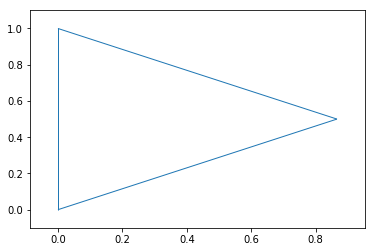

In [95]:
triangle = torch.FloatTensor([
    tri_grid_point(0, 0), 
    tri_grid_point(0, 1), 
    tri_grid_point(1, 0)
])
triangle = torch.flip(triangle, [0])

plot_polygon(triangle)
ind = np.array([[0, 1, 2], [1, 2, 0], [2, 0, 1]])
angle_coords = group_points(triangle, ind)
print(get_angles(angle_coords))
angle_loss(angle_coords, torch.FloatTensor([np.pi/3] * 3))


### Viscous Dampening Optimizer

Idea for indexing points by edges: exclusive sets or (sparse array + sum).

The latter works well!

In [31]:
from torch.optim import Optimizer

class ViscousDampeningOptimizer(Optimizer):
    def __init__(self, params, connections, timestep, dampening, viscous_dampening):
        defaults = dict(
            timestep=timestep, 
            dampening=dampening, 
            viscous_dampening=viscous_dampening
        )
        param_info = [dict(
            params=par, 
            connections=torch.LongTensor(con), 
            velocities=torch.zeros_like(par)
        ) for par, con in zip(params, connections)]
        super(ViscousDampeningOptimizer, self).__init__(param_info, defaults)
        
    def step(self):
        for group in self.param_groups:
            dampening = group['dampening']
            viscous_dampening = group['viscous_dampening']
            timestep = group['timestep']
            params = group['params']
            assert len(params) == 1, f'{len(params)}'
            params = params[0]
            connections = group['connections']
            velocities = group['velocities']
            
            if connections is not None:
                # viscous dampening
                velocity_diffs = torch.sparse.sum(
                    torch.sparse.FloatTensor(
                        connections.t(), 
                        group_points(velocities, connections) * torch.FloatTensor([[[1], [-1]]]), 
                        torch.Size([pts.shape[0], pts.shape[0], 2, 2])
                    ),
                    dim=2
                )
                viscous_forces = torch.sparse.sum(velocity_diffs, dim=0) - torch.sparse.sum(velocity_diffs, dim=1)
                viscous_forces = viscous_forces.to_dense()
                velocities += timestep * viscous_dampening * viscous_forces
            
            velocities -= timestep * params.grad
            params.data.add_(timestep * velocities)
            velocities *= (1 - dampening)

Examples

In [6]:
# Unit vector in direction alpha

def U(alpha):
    return np.stack([np.sin(alpha), np.cos(alpha)], axis=-1)

def tri_grid_point(i, j):
    return U(0) * i + U (np.pi / 3) * j

In [7]:
tri_grid_point(1, 0)

array([0., 1.])

In [8]:
pts = torch.FloatTensor([[1, 2], [2, 4], [3, 6], [4, 8]]).requires_grad_()
ind = torch.LongTensor([[0, 0], [1, 2], [3, 2]])
#ind = torch.LongTensor([[0, 0, 0], [1, 2, 3]])
loss = torch.sum(group_points(pts, ind))
loss.backward()



In [9]:
# plotting

def show_lines(points, connections):
    plt.scatter(points[:, 0], points[:, 1])
    lines = [np.array([points[i], points[j]]) for (i, j) in connections]
    lc = mc.LineCollection(lines, linewidths=1)
    ax = plt.gca()
    ax.add_collection(lc)
    ax.set_aspect('equal', adjustable='box')
    ax.margins(0.05)
        
def show_offsets(points, offsets):
    lines = [[p, p+o] for p, o in zip(points, offsets)]
    lc = mc.LineCollection(lines, linewidths=1, colors='red')
    ax = plt.gca()
    ax.add_collection(lc)

angle_ids (216, 3)
iteration      0, loss: 143.77772521972656


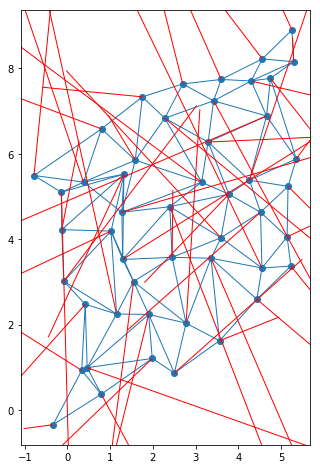

iteration   1000, loss: 0.12469059973955154


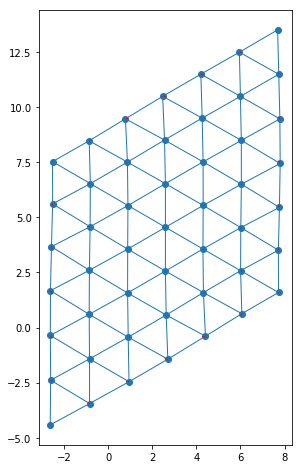

iteration   2000, loss: 1.0106489658355713


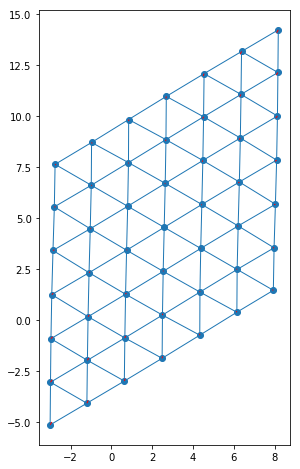

iteration   3000, loss: 0.05188059061765671


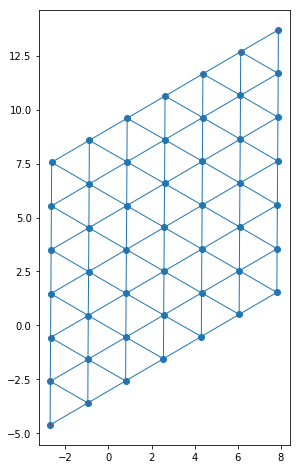

iteration   4000, loss: 0.015194321051239967


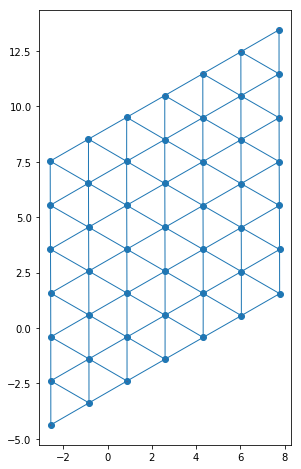

iteration   5000, loss: 0.0031828368082642555


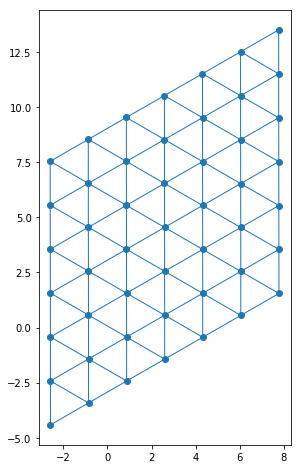

iteration   6000, loss: 0.00011062937846872956


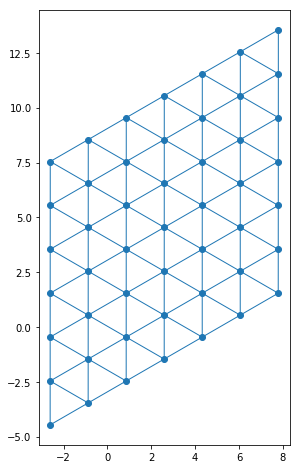

iteration   7000, loss: 0.00011475749488454312


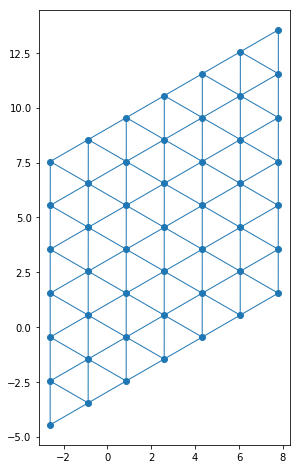

iteration   8000, loss: 2.7151207859787974e-07


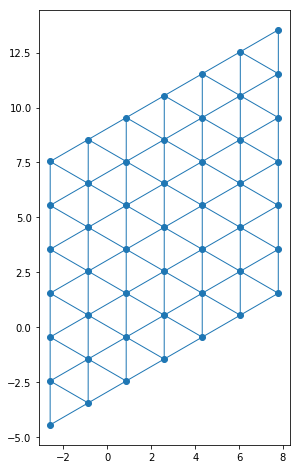

iteration   9000, loss: 2.8263984859222546e-06


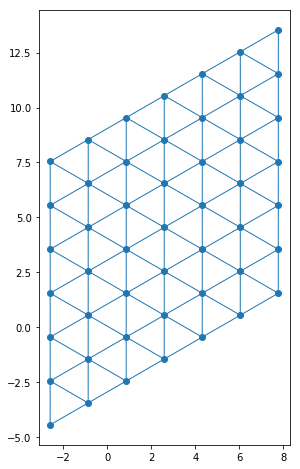

In [97]:
shape = (7, 7)
ind = np.moveaxis(np.mgrid[:shape[0],:shape[1]], 0, -1).reshape(-1, 2)
rev = np.arange(np.prod(shape), dtype=np.int32).reshape(shape)
pts = np.stack([tri_grid_point(*ij) for ij in ind])

# define grid of connections
connections = []
for i in range(shape[0]):
    for j in range(shape[1] - 1):
        connections.append([[i, j], [i, j + 1]])
for i in range(shape[0] - 1):
    for j in range(shape[1]):
        connections.append([[i, j], [i + 1, j]])
for i in range(shape[0] - 1):
    for j in range(shape[1] - 1):
        connections.append([[i, j + 1], [i + 1, j]])
connections = [[rev[i, j] for (i, j) in con] 
               for con in connections]
connections = np.array(connections)

# define tuples for angles
cyclic_offsets = np.array([[0, -1], [1, -1], [1, 0]])
cyclic_offsets = np.concatenate([cyclic_offsets, -cyclic_offsets])
offset_pairs = np.stack([
    cyclic_offsets, 
    np.concatenate([cyclic_offsets[1:], cyclic_offsets[:1]])
], axis=1)
def in_range(i, j):
    return (0 <= i < shape[0]) and (0 <= j < shape[1])

angle_ids = []
for i in range(shape[0]):
    for j in range(shape[0]):
        ij = np.array([i, j])
        for off0, off1 in offset_pairs:
            if in_range(*(ij + off0)) and in_range(*(ij + off1)):
                angle_ids.append([ij+off0, ij, ij+off1])
angle_ids = [[rev[i, j] for (i, j) in ang] 
               for ang in angle_ids]
angle_ids = np.array(angle_ids)
print('angle_ids', angle_ids.shape)
                
# convert points to tensor
n = len(pts)
pts = torch.FloatTensor(pts)

# generate gt_angles
angle_coords = group_points(pts, angle_ids)
gt_angles = get_angles(angle_coords)

# add small offset to points
torch.random.manual_seed(0)
pts += torch.randn(pts.shape) * 0.3
pts = pts.detach().requires_grad_()

# set up plotting
def plot_stuff():
    plt.figure(figsize=(8, 8))
    pts_np = pts.detach().numpy()
    show_lines(pts_np, connections)
    grad_np = pts.grad.numpy()
    show_offsets(pts_np, -0.9 * grad_np)
    plt.show()
    
# set up optimization
from torch.optim import SGD

lr = 1e-2
optimizer = ViscousDampeningOptimizer(
    [pts], 
    [connections],
    timestep=lr,
    dampening=0.00,
    viscous_dampening=0.8
)

#optimizer = SGD([pts], lr=lr, momentum=0.9, dampening=0.5)
log_every = 1000

# get ground truth lengths
segments = group_points(pts, connections)
gt_lengts = torch.ones(len(segments))*2.0

#plot_stuff()
for i in range(10000):
    optimizer.zero_grad()
    segments = group_points(pts, connections)
    loss = 1 * distance_loss(segments, gt_lengts)
    loss += 1 * angle_loss(group_points(pts, angle_ids), gt_angles)
    loss.backward()
    optimizer.step()
    if i % log_every == 0:
        print(f'iteration {i:6}, loss: {loss.item()}')
        plot_stuff()



In [97]:
group_points(pts, connections).shape

(261, 2, 2)

In [248]:
a = torch.tensor([1, 2, 3])

a

tensor([1, 2, 3])

In [269]:
i = torch.LongTensor([[2, 1, 5], [4, 3, 0]])
v = torch.FloatTensor([[5, 6], [-1, 100], [7,7]])
torch.sparse.sum(torch.sparse.FloatTensor(i, v), dim=-1).to_dense()

tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 99.,  0.],
        [ 0.,  0.,  0.,  0., 11.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [14.,  0.,  0.,  0.,  0.]])

In [270]:
connections.shape

(120, 2)

In [272]:
group_points(pts, connections).shape

torch.Size([120, 2, 2])

In [297]:
ind = torch.LongTensor(connections)
val = group_points(pts.grad, connections) * torch.FloatTensor([[[1], [-1]]])
velocity_diffs = torch.sparse.sum(
    torch.sparse.FloatTensor(
        torch.LongTensor(connections).t(), 
        val, 
        torch.Size([pts.shape[0], pts.shape[0], 2, 2])
    ),
    dim=2
)
viscous_dampening = torch.sparse.sum(velocity_diffs, dim=0) - torch.sparse.sum(velocity_diffs, dim=1)
viscous_dampening = viscous_dampening.to_dense()
viscous_dampening.shape

torch.Size([49, 2])

torch.Size([49, 2])

### dof estimate
$E$ edges, $F$ faces, $V$ vertices

degrees of freedom: $ 3 F $ (2 for position, 1 for rotation)
constraints:
- $E_{\text{inner}}$ for distances between faces
- $\sum\limits_{n \in \text{Nodes}} \left(\text{degree}(n) - 3\right) = 2E - 3N$

Hence, dof - constraints = $3 (F - E + N)$ = 1 (according to eulers formula for plane graphs)

This sounds very promising!

-------------------------------

For triangles only:
$\text{degree} = 6$, $E = 3F/2$, $N = 3F/6 = F/2$

Hence,
dof - constraints = $ F \, (3 - \frac{3}{2} - \frac{3}{2}) = 0 $
    
For 4-gons:
dof - constraints = $ F \, (3 - \frac{4}{2} - \frac{1}{1}) = 0 $

For 6-gons: 
dof - constraints = $ F \, (3 - \frac{6}{2} - 0) = 0 $

Not True: (Overconstrained in all cases (if no boundary present). Thus: Allow wiggle in 'ground truth' tesselation)

Wiggle in 'ground truth' tesselation might still make sense
    
TODO: take inner vs outer into account

The above was previously incorrect! The last constraint for every node is automatically fulfilled, hence $\text{degree}(n) - 3$ not just $ -2 $

In [12]:
a = torch.FloatTensor([0, 1, -1])
b = torch.FloatTensor([1, 0, 0])
torch.atan2(a, b) / np.pi

tensor([ 0.0000,  0.5000, -0.5000])